In [1]:
%load_ext autoreload
%autoreload 2

# Get parent directory and add to sys.path
import os; import sys
import numpy as np
parent_dir = os.path.dirname(os.getcwd())
sys.path.append(parent_dir)

# Require ipympl
%matplotlib widget 

In [2]:
# MPC import
from MPCVelControl_D5_1 import MPCVelControl
from PIControl.PIControl import PIControl

from src.rocket import Rocket
from src.vel_rocket_vis import RocketVis, plot_static_states_inputs

rocket_obj_path = os.path.join(parent_dir, "Cartoon_rocket.obj")
rocket_params_path = os.path.join(parent_dir, "rocket.yaml")

In [3]:


Ts = 0.05
sim_time = 15; 
H = 6.0
x0 = np.array([0, 0, 0, 0, 0, 0, 5, 5, 10, 0, 0, 1])  # initial state
x_target = np.zeros((12,))

rocket = Rocket(Ts=Ts, model_params_filepath=rocket_params_path)
mpc = MPCVelControl().new_controller(rocket, Ts, H)

# Static mass change and zero fuel rate
rocket.mass = 1.5
rocket.fuel_rate = 0.0
t_cl, x_cl, u_cl, t_ol, x_ol, u_ol, ref = rocket.simulate_control(mpc, sim_time, H, x0, x_target=x_target, method='nonlinear')

vis = RocketVis(rocket, rocket_obj_path)
vis.anim_rate = 1.0
#vis.animate(t_cl[:-1], x_cl[:,:-1], u_cl, Ref=ref[:,:-1], T_ol=t_ol[...,:-1], X_ol=x_ol, U_ol=u_ol); 
vis.animate(t_cl[:-1], x_cl[:,:-1], u_cl); 






******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

Maximum invariant set found after 15 iterations !

Maximum invariant set found after 15 iterations !

Maximum invariant set found after 18 iterations !

Simulating time 0.00: r =  [0.]
Steady state xs (z-velocity):  [0.]
Steady state us (z-velocity):  [-0.]
Estimated disturbance (z-velocity):  [271.94234822]
Estimated state (z-velocity):  [9.]

Simulating time 0.05: r =  [0.]
Steady state xs (z-velocity):  [0.]
Steady state us (z-velocity):  [-271.94234822]
Estimated disturbance (z-velocity):  [295.77768237]
Estimated state (z-velocity):  [12.08301634]

Simulating time 0.10: r =  [0.]
Steady state xs (z-ve

AppLayout(children=(HBox(children=(Play(value=0, description='Press play', max=299, step=2), IntSlider(value=0…

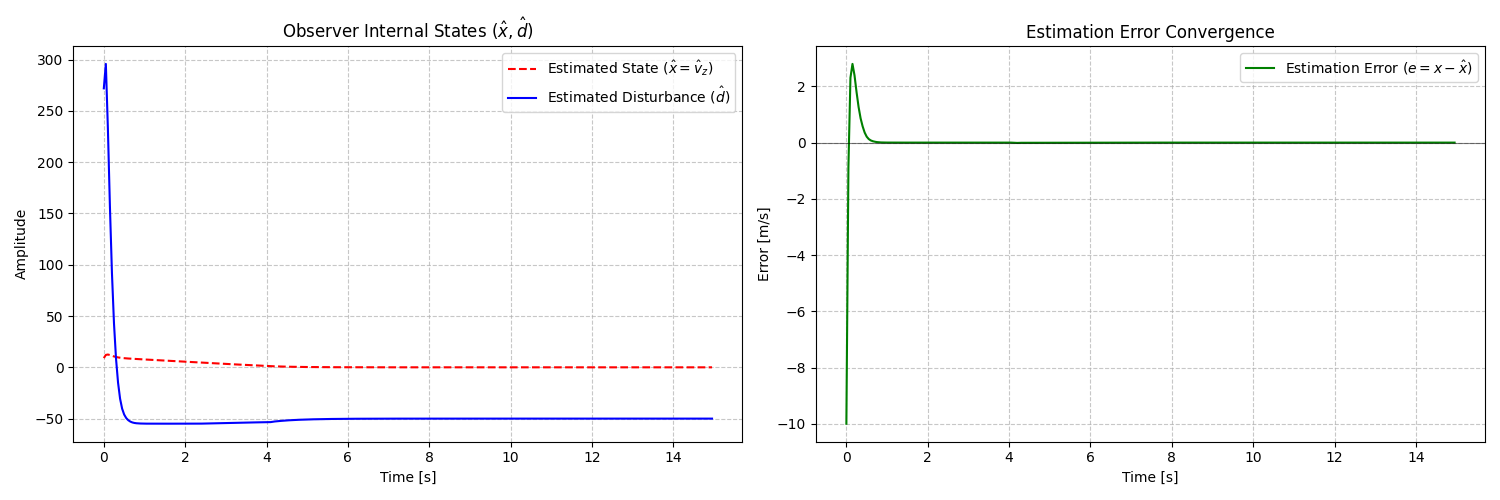

In [4]:
import matplotlib.pyplot as plt
import numpy as np

def plot_observer_complete(t_vector, x_estimated, x_error, d_estimated):
    """
    Plots the estimated state, estimated disturbance, and estimation error.
    Uses raw strings (r'') to avoid SyntaxWarnings with LaTeX backslashes.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # --- Subplot 1: Estimator Internal States ---
    # Using r'...' ensures \hat is treated as LaTeX, not a Python escape sequence
    ax1.plot(t_vector, x_estimated, 'r--', linewidth=1.5, label=r'Estimated State ($\hat{x} = \hat{v}_z$)')
    ax1.plot(t_vector, d_estimated, 'b-', linewidth=1.5, label=r'Estimated Disturbance ($\hat{d}$)')
    ax1.set_title(r"Observer Internal States ($\hat{x}, \hat{d}$)", fontsize=12)
    ax1.set_xlabel("Time [s]", fontsize=10)
    ax1.set_ylabel("Amplitude", fontsize=10)
    ax1.legend(loc='best')
    ax1.grid(True, linestyle='--', alpha=0.7)

    # --- Subplot 2: Estimation Error (Innovation) ---
    ax2.plot(t_vector, x_error, 'g-', linewidth=1.5, label=r'Estimation Error ($e = x - \hat{x}$)')
    ax2.axhline(0, color='black', linestyle='-', linewidth=0.8, alpha=0.5)
    
    ax2.set_title("Estimation Error Convergence", fontsize=12)
    ax2.set_xlabel("Time [s]", fontsize=10)
    ax2.set_ylabel("Error [m/s]", fontsize=10)
    ax2.legend(loc='best')
    ax2.grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

plot_observer_complete(t_cl[:-1],np.array(mpc.mpc_z.x_hat_history),np.array(mpc.mpc_z.estimation_error_history),np.array(mpc.mpc_z.d_history)) 

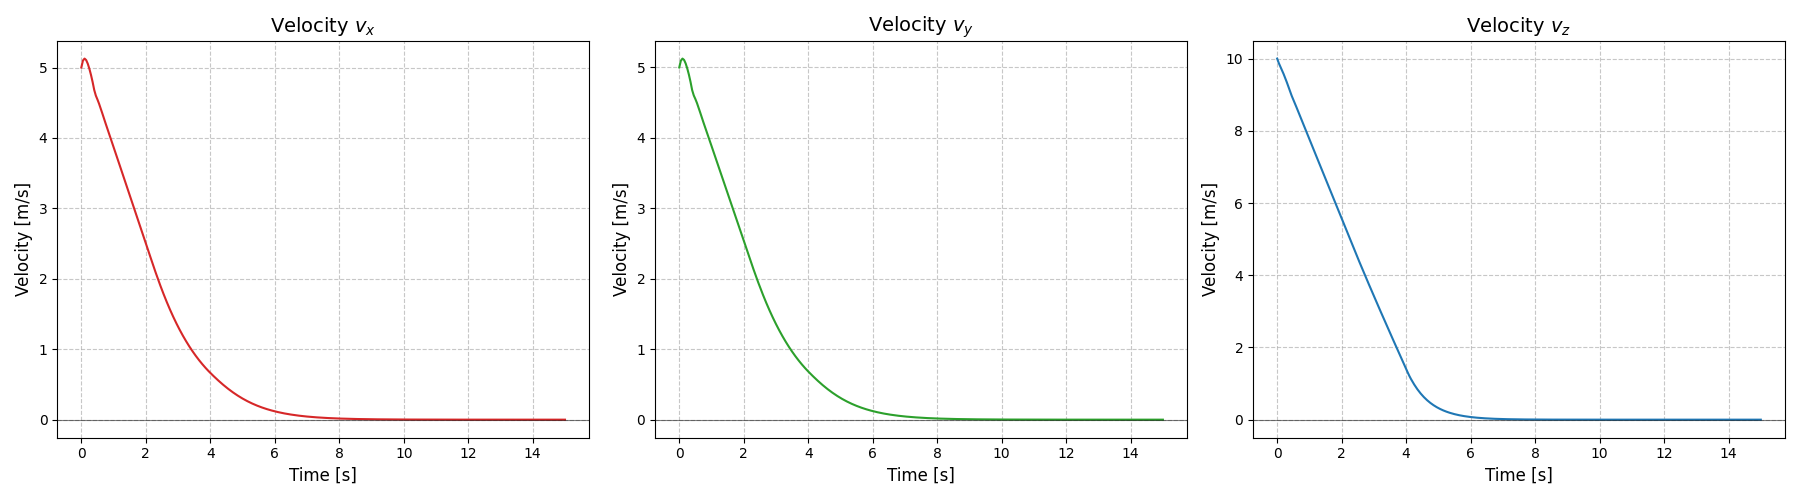

In [5]:
def plot_velocities_side_by_side(t_vector, x_trajectory):
    """
    Plots vx, vy, and vz velocities side-by-side.
    
    Args:
        t_vector: Time vector from simulation (t_cl)
        x_trajectory: Full state trajectory (12 x N matrix)
    """
    # Define indices for velocities: vx=6, vy=7, vz=8
    v_indices = [6, 7, 8]
    v_names = [r'$v_x$', r'$v_y$', r'$v_z$']
    v_colors = ['tab:red', 'tab:green', 'tab:blue']

    fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=False)

    for i, ax in enumerate(axes):
        idx = v_indices[i]
        ax.plot(t_vector, x_trajectory[idx, :], color=v_colors[i], linewidth=1.5)
        
        ax.set_title(f"Velocity {v_names[i]}", fontsize=14)
        ax.set_xlabel("Time [s]", fontsize=12)
        ax.set_ylabel("Velocity [m/s]", fontsize=12)
        ax.grid(True, linestyle='--', alpha=0.7)
        
        # Add a horizontal line at 0 for reference
        ax.axhline(0, color='black', linestyle='-', linewidth=0.8, alpha=0.5)

    plt.tight_layout()
    plt.show()

plot_velocities_side_by_side(t_cl, x_cl)

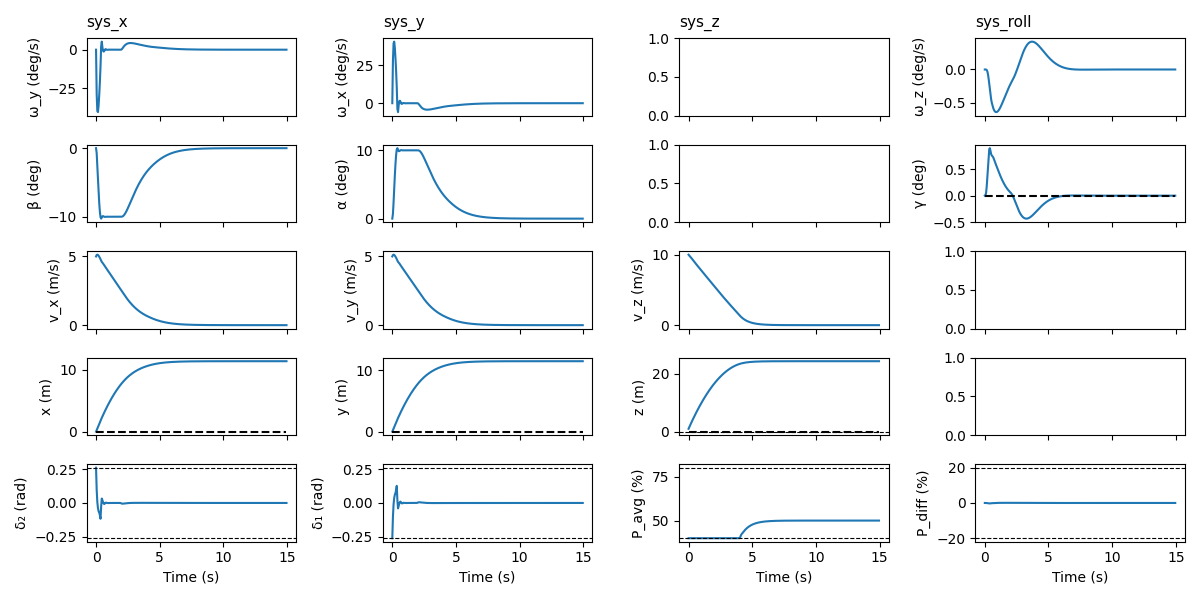

In [6]:
plot_static_states_inputs(t_cl[:-1], x_cl[:,:-1], u_cl, ref[:,:-1])